## Segment and modify an image to produce value images

In [10]:
# General imports
import numpy as np
import os, sys
from datetime import datetime

In [24]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_lists, write_lists, ensure_dir, list_to_dict, read_json, load_image, informal_log
from utils.model_utils import prepare_device
from parse_config import ConfigParser
from segment import segment_modify_save

In [37]:
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
incorrect_images_path = 'metadata/CINIC10-ImageNet/cat/vgg16_bn/incorrect_image_paths.txt'
log_path = 'temp/1000_dog_edit_image/log.txt'
n_select = 200
seed = 0 # Set to None if want true randomness

In [38]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [40]:
### Obtain incorrect images to use for edit
all_incorrect_images = np.array(read_lists(incorrect_images_path))
n_images = len(all_incorrect_images)
np.random.seed(seed)
# key_images = all_incorrect_images[np.random.randint(n_images, size=n_select)]
# TODO: NEED TO TEST
rng = np.random.default_rng()
random_idxs = rng.choice(n_images, size=n_select, replace=False)
assert len(set(random_idxs)) == len(list(random_idxs))
key_images = all_incorrect_images[random_idxs]
# key_images = key_images[20:]


## Define variables shared across all images

In [41]:
# Obtain class list
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_to_idx_dict = list_to_dict(class_list)

# General save directories
save_dir_root = os.path.join('saved', 'segmentations')
if not os.path.isdir(save_dir_root):
    os.makedirs(save_dir_root)


# Set parameters for segmentation
felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Set segmentation methods
methods = []
methods.append(('felzenszwalb', felzenszwalb_params))
methods.append(('quickshift', quickshift_params))
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))

In [42]:
# Load config file, and class names file
config_json = read_json(config_path)
config = ConfigParser(config_json, make_dirs=False)
class_names = read_lists(class_list_path)

## Loop across selected images to make edit image pairs

In [43]:
original_image_paths = {}
modified_image_paths = {}
seed = 0
for idx, image_path in enumerate(key_images):
    if idx % 50 == 0:
        informal_log("\n!!!\n", log_path)
        informal_log("Processing {}/{}...".format(idx+1, len(key_images)), log_path)
        informal_log("\n!!!\n", log_path)
    # Extract information for this image
    split = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
    class_name = os.path.basename(os.path.dirname(image_path))
    file_name = os.path.basename(image_path).split(".")[0]
    image_name = "{}-{}-{}".format(class_name, split, file_name)
    
    # Class save_dir
    class_save_dir = os.path.join(save_dir_root, class_name)

    # Load image
    image = load_image(image_path, data_format='CHW')

    # Obtain target class
    target_class_idx = class_to_idx_dict[class_name] # 5 = dog

    cur_modified_image_paths = (segment_modify_save(
        image=image,
        image_name=image_name,
        segmentation_methods_params=methods,
        seed=seed,
        save_dir_root=class_save_dir,
        config=config,
        target_class_idx=target_class_idx,
        log_path=log_path,
        save_segmentations=True,
        save_visualizations=False))

    cur_original_image_paths = [image_path for i in range(len(cur_modified_image_paths))]
    assert len(cur_modified_image_paths) == len(cur_original_image_paths)

    # Add to master dictionary (separated by class)
    if class_name in original_image_paths:
        original_image_paths[class_name] += cur_original_image_paths
        modified_image_paths[class_name] += cur_modified_image_paths
    else:
        original_image_paths[class_name] = cur_original_image_paths
        modified_image_paths[class_name] = cur_modified_image_paths


!!!

Processing 1/200...

!!!

Made save directory at saved/segmentations/cat/cat-train-n02120997_15889
Segmentations will be saved as .pth to saved/segmentations/cat/cat-train-n02120997_15889/segmentations.pth
Successfully modified images will be saved in saved/segmentations/cat/cat-train-n02120997_15889/modified_images
Saving segmentations to saved/segmentations/cat/cat-train-n02120997_15889/segmentations.pth
felzenszwalb segmentation had 1 sucessful modification(s)...
  felzenszwalb_masked_3.png
watershed segmentation had 1 sucessful modification(s)...
  watershed_masked_2.png
(2, 3, 32, 32)
Saving image to saved/segmentations/cat/cat-train-n02120997_15889/modified_images/felzenszwalb_masked_3.png
Saving image to saved/segmentations/cat/cat-train-n02120997_15889/modified_images/watershed_masked_2.png
Made save directory at saved/segmentations/cat/cat-train-n02128757_4479
Segmentations will be saved as .pth to saved/segmentations/cat/cat-train-n02128757_4479/segmentations.pth
Succes

In [44]:
# Save image paths
n_modified_total = 0
for class_name in original_image_paths.keys():
    save_paths_dir = os.path.join('paths', 'edits', class_name, timestamp)
    ensure_dir(save_paths_dir)

    save_original_paths_path = os.path.join(save_paths_dir, 'key_images.txt')
    save_modified_paths_path = os.path.join(save_paths_dir, 'value_images.txt')

    write_lists(save_original_paths_path, original_image_paths[class_name])
    write_lists(save_modified_paths_path, modified_image_paths[class_name])

    n_modified_total += len(original_image_paths[class_name])
print("Paths to images are saved as .txt files in {}".format(save_paths_dir))
print("Saved total of {} edit image pairs".format(n_modified_total))

Paths to images are saved as .txt files in paths/edits/cat/0113_155703
Saved total of 1728 edit image pairs


# FIN


# Perform segmentation on image

### Set parameters

In [8]:
# Load image




### Segment image

In [9]:
# Segment image using each method and modify each segment
# segmentations = []
# gaussian_modified_images = []
# masked_modified_images = []

# for method, params in methods:
#     print("Performing segmentation with {}".format(method))
#     segments = segmentation_utils.segment(
#         image,
#         method=method,
#         kwargs=params)
#     segmentations.append(segments)

#     # Modify segments with noise
#     gaussian_modified_images.append(segmentation_utils.modify_segments(
#         image,
#         segments=segments,
#         method='gaussian_noise',
#         mean=0,
#         std=0.1,
#         seed=seed))

#     # Modify segments with masking
#     masked_modified_images.append(segmentation_utils.modify_segments(
#         image=image,
#         segments=segments,
#         method='mask'))

# save_data = {
#     "original_image": image,  # np.array
#     "segmentation_methods": methods,  # list[(str, dict)]
#     "segmentations": segmentations,  # list[np.array]
#     "gaussian_modified_images": gaussian_modified_images,  # list[list[np.array]]
#     "masked_modified_images": masked_modified_images  # list[list[np.array]]
# }

# torch.save(save_data, segmentations_save_path)
# print("Segmentation data saved to {}".format(segmentations_save_path))

Performing segmentation with felzenszwalb
Performing segmentation with quickshift
Performing segmentation with slic
Performing segmentation with watershed
Segmentation data saved to saved/segmentations/dog-train-n02114712_211/segmentations.pth


#### Visualizations


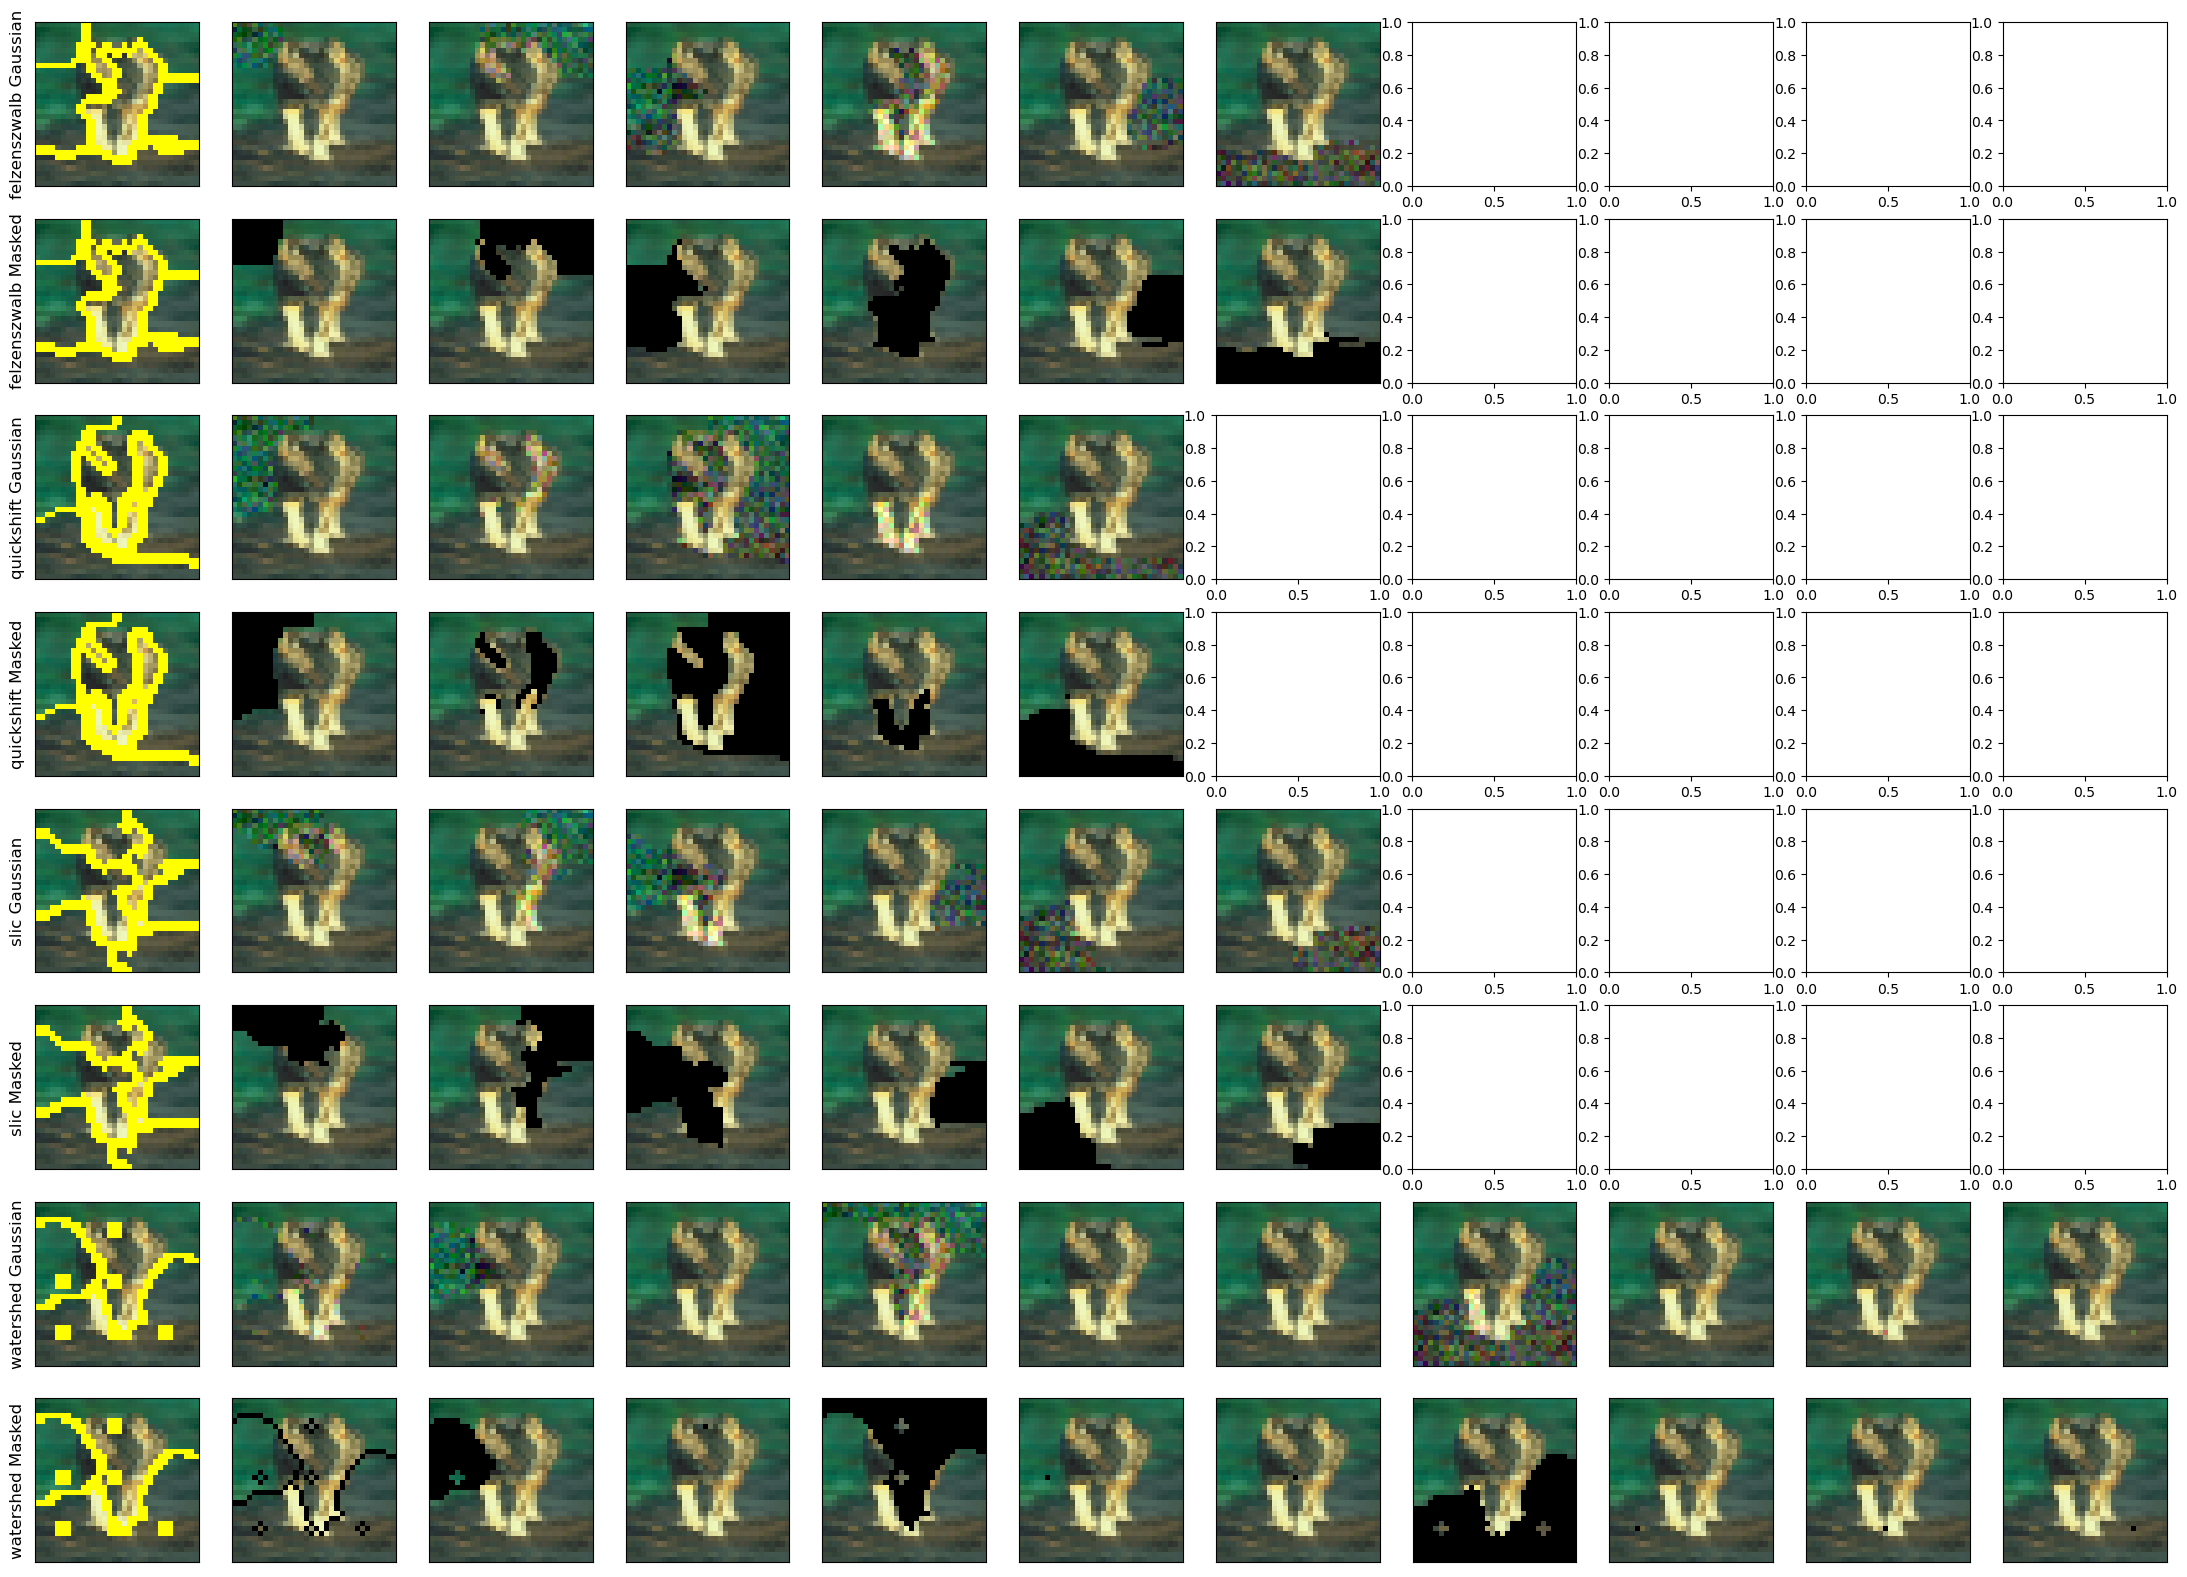

Saved visualization to saved/segmentations/dog-train-n02114712_211/segment-visualizations.png


In [10]:
# visualization_grid = []
# row_labels = []
# max_row_len = 0
# for idx, (method, _) in enumerate(methods):
#     cur_segmentation = segmentations[idx]
#     segmentation_overlay = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), cur_segmentation)
#     # overlay segmentation onto image
#     gaussian_modified_row = gaussian_modified_images[idx]
#     masked_modified_row = masked_modified_images[idx]
    
#     # Top row will be for Gaussian
#     row_labels.append(method + ' Gaussian')
#     row_images = [segmentation_overlay] + gaussian_modified_row 
#     visualization_grid.append(row_images)
    
#     # Bottom row will be for masked
#     row_labels.append(method + ' Masked')
#     row_images = [segmentation_overlay] + masked_modified_row
#     visualization_grid.append(row_images)
    
#     if len(row_images) > max_row_len:
#         max_row_len = len(row_images)
        
# # Pad extra columns with None
# for idx, row in enumerate(visualization_grid):
#     n_pad = max_row_len - len(row)
#     padding = [None for i in range(n_pad)]
#     visualization_grid[idx] = row + padding

# for row in visualization_grid:
#     assert len(row) == max_row_len
        
# # Save path
# visualization_save_path = os.path.join(save_dir, 'segment-visualizations.png')
# visualizations.show_image_rows(
#     images=visualization_grid,
#     row_labels=row_labels,
#     save_path=visualization_save_path)
# print("Saved visualization to {}".format(visualization_save_path))

### Load model and run images through the model

In [11]:
# Load model
layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum)
model.eval()

CIFAR10PretrainedModelEdit(
  (model): VGG(
    (normalize): InputNormalize()
    (layer0): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer3): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, moment

In [12]:
# Load the checkpoint with keys 
save_data = torch.load(segmentations_save_path)

# Unpack data
original_image = save_data['original_image']
original_image = np.expand_dims(original_image, axis=0)
original_image = torch.from_numpy(original_image).type(torch.FloatTensor).to(device)
methods = save_data['segmentation_methods']
all_gaussian_modified_images = save_data['gaussian_modified_images']
all_masked_modified_images = save_data['masked_modified_images']

# Create lists for storing logits
all_gaussian_modified_logits = []
all_masked_modified_logits = []

felzenszwalb segmentation had 3 sucessful modification(s)...
  felzenszwalb_gaussian_0.png
  felzenszwalb_masked_0.png
  felzenszwalb_masked_1.png
quickshift segmentation had 1 sucessful modification(s)...
  quickshift_masked_0.png
slic segmentation had 1 sucessful modification(s)...
  slic_masked_0.png
watershed segmentation had 1 sucessful modification(s)...
  watershed_masked_1.png
Total of 6 modifications produced correct predictions.


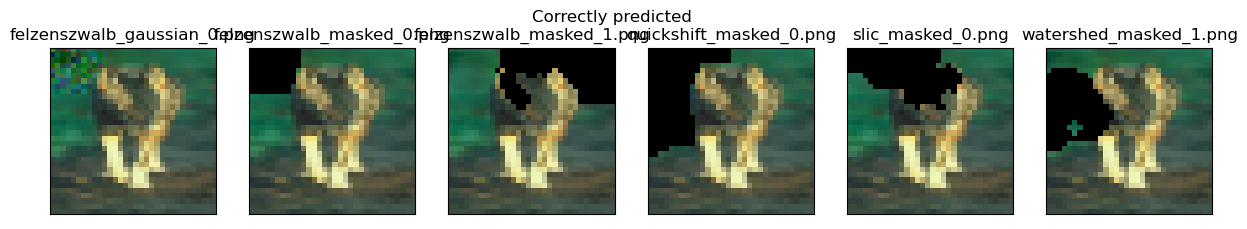

In [13]:
# Pass original image through first to get logits
with torch.no_grad():
    original_logits = model(original_image)
    original_logits = original_logits.cpu().numpy()

success_modifications = []  # store images
success_names = []  # store strings

original_image_numpy = np.squeeze(original_image.cpu().numpy())
# Pass images through model to get predictions
for idx, (method, _) in enumerate(methods):
    
    # Index into current modified images
    gaussian_modified_images = all_gaussian_modified_images[idx]
    masked_modified_images = all_masked_modified_images[idx]
    n_modified = len(gaussian_modified_images)
    # Stack along batch dimension
    all_images = np.stack(gaussian_modified_images + masked_modified_images, axis=0)
    # Convert to tensor & switch to GPU
    all_images = torch.from_numpy(all_images).type(torch.FloatTensor)
    all_images = all_images.to(device)
    
    # Forward through model
    with torch.no_grad():
        all_logits = model(all_images)
        
    # Obtain indices where the prediction is the target
    all_predictions = torch.argmax(all_logits, dim=1)
    success_idxs = (all_predictions == target).nonzero().squeeze(dim=-1)
    
    # Store images in respective list
    success_images = all_images[success_idxs]
    # If only one image, expand dims to be 1 x C x H x W
    if len(success_images.shape) == 3:
        success_images = torch.unsqueeze(success_images, dim=0)
    success_modifications.append(success_images)
    
    # Store names of each image in respective list
    if success_idxs.shape[0] != 0:
        print("{} segmentation had {} sucessful modification(s)...".format(method, success_idxs.shape[0]))
        for idx in success_idxs:
            if idx < n_modified:
                mod_type = 'gaussian'
            else: 
                mod_type = 'masked'
            name = "{}_{}_{}.png".format(method, mod_type, idx % n_modified)
            success_names.append(name)
            
            print("  {}".format(name))
        
            
    '''
    Rest of loop is extra data analysis
    '''
#     # Separate modified logits from one another and append to respective lists
#     gaussian_modified_logits = all_logits[0:n_modified].cpu().numpy()
#     masked_modified_logits = all_logits[n_modified:].cpu().numpy()
#     # Add to master lists
#     all_gaussian_modified_logits.append(gaussian_modified_logits)
#     all_masked_modified_logits.append(masked_modified_logits)
    
#     # Get indices for gaussian noise modifications with most change
#     gaussian_indices = segmentation_utils.get_most_changed_idxs(
#         anchor=original_logits,
#         data=gaussian_modified_logits,
#         target=target)
    
#     # Get indices for masked modifications with most change
#     masked_indices = segmentation_utils.get_most_changed_idxs(
#         anchor=original_logits,
#         data=masked_modified_logits,
#         target=target)
    
# Visualize the successful modifications
success_modifications = torch.cat(success_modifications, dim=0).cpu().numpy()
print("Total of {} modifications produced correct predictions.".format(len(success_names)))
visualizations.show_image_rows(
    images=[list(success_modifications)],
    image_titles=[success_names],
    figure_title='Correctly predicted')
    

In [14]:
# Save images
    
save_paths = []
for name, image in zip(success_names, success_modifications):
    save_path = os.path.join(image_save_dir, name)
    utils.write_lists(os.path.join(save_paths_dir, name.replace('png', 'txt')), [save_path])
    save_paths.append(save_path)
    utils.save_image(image, save_path)
    
paths_save_path = os.path.join(save_paths_dir, 'correct_images.txt')
utils.write_lists(paths_save_path, save_paths)
# TODO: add write lists of incorrect images * # of correct images
# utils.write_lists(os.path.join(save_paths_dir, 'incorrect_image.txt'), [image_path])

# Print progress
print("Modified images saved to {}".format(image_save_dir))
print("Paths to images saved individually in {}".format(save_paths_dir))
print("Paths to all modified images saved to {}".format(paths_save_path))

Modified images saved to saved/segmentations/dog-train-n02114712_211/modified_images
Paths to images saved individually in paths/edits/dog-train-n02114712_211
Paths to all modified images saved to paths/edits/dog-train-n02114712_211/correct_images.txt


## Example of performing and visualizing segmentations for multiple images

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


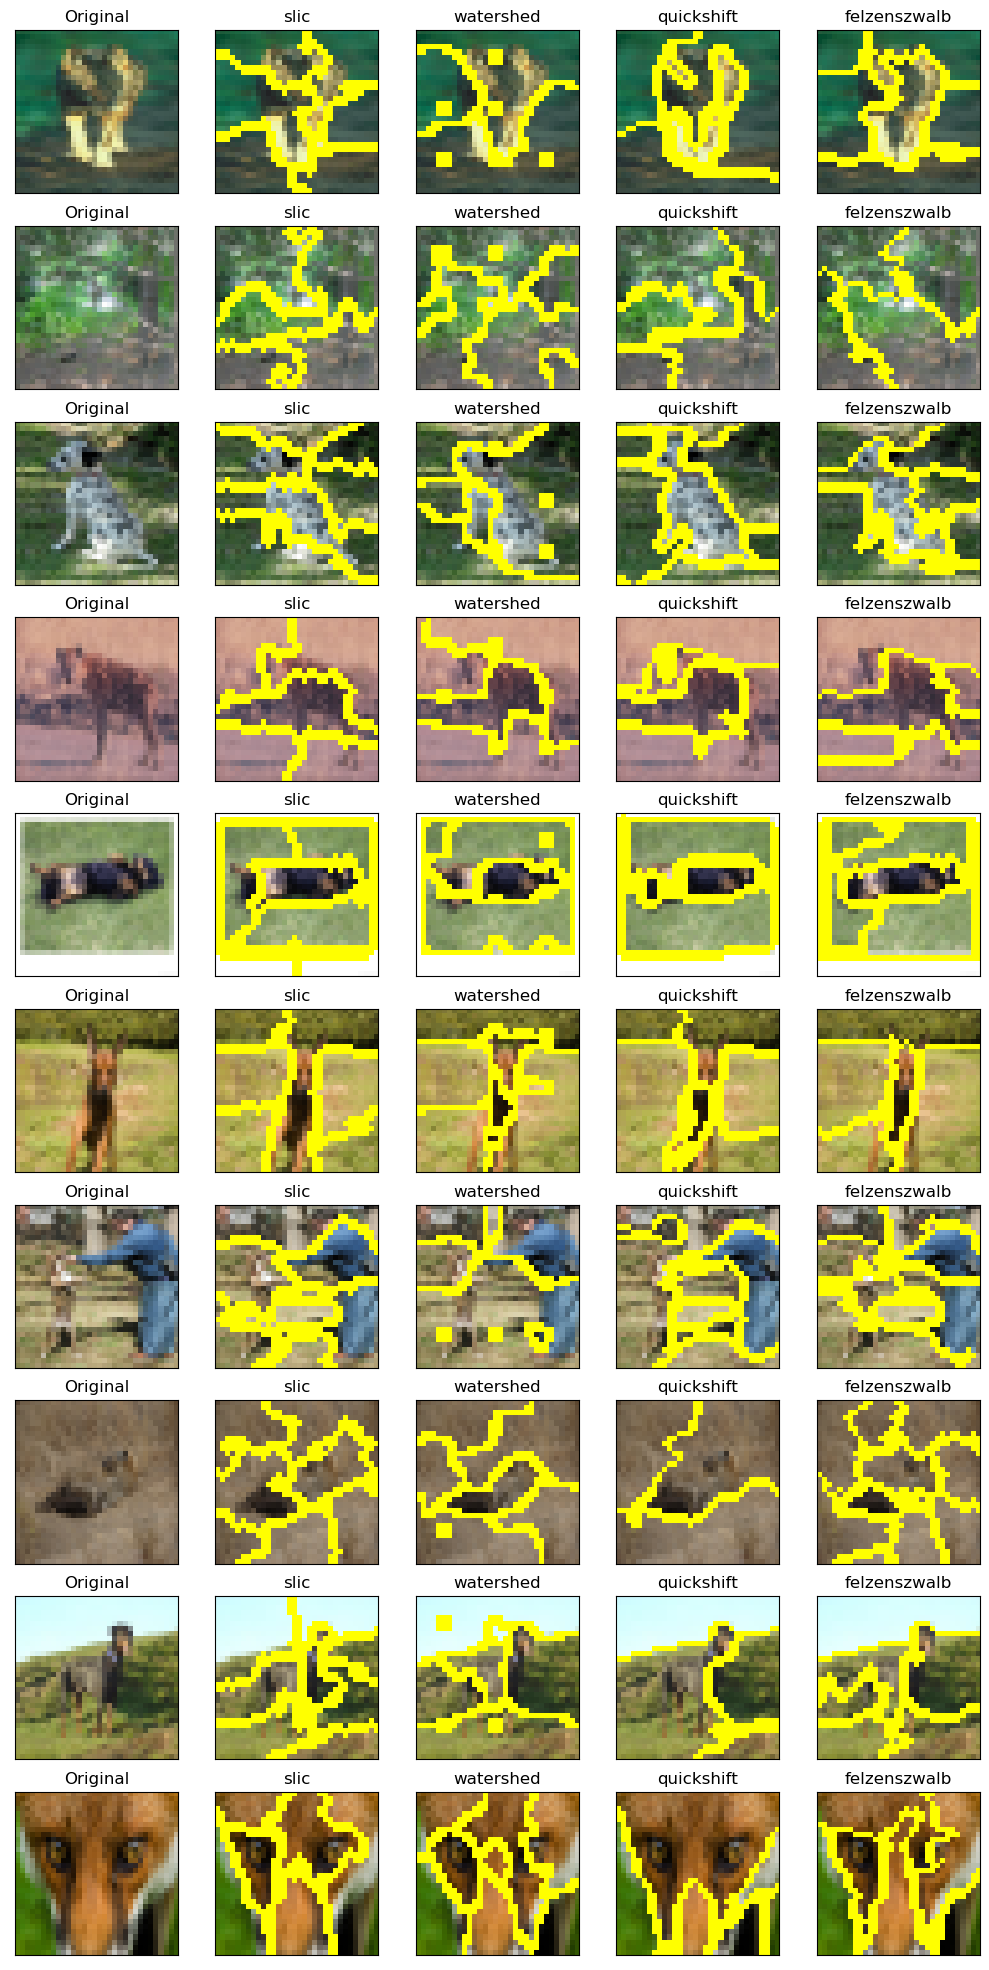

In [119]:
image_paths_path = os.path.join('paths', 'edits', 'dog', 'keys', 'key_image_paths.txt')
image_paths = utils.read_lists(image_paths_path)

felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    # 'channel_axis': 0,
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
    # 'channel_axis': 0
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Create list of methods and corresponding parameters
methods = []
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))
# methods.append(('quickshift', {}))
methods.append(('quickshift', quickshift_params))
# methods.append(('felzenszwalb', {}))
methods.append(('felzenszwalb', felzenszwalb_params))
n_methods = len(methods)

images = []
titles = []

for path in image_paths:
    image = utils.load_image(path)
    images.append(image)
    titles.append('Original')
    for method, method_params in methods:
        labels = segment(
            image,
            method=method,
            params=method_params)

        annotated_image = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), labels)
        images.append(annotated_image)
        titles.append(method)

print(type(images[0]))
images = visualizations.make_grid(images, items_per_row=n_methods+1)
titles = visualizations.make_grid(titles, items_per_row=n_methods+1)
print(type(images))
print(type(images[0]))
print(type(images[0][0]))
visualizations.show_image_rows(
    images,
    image_titles=titles)
    # save_path='visualizations/segmentation_comparison.png')